Multi Layer Perceptron - Model
----

Based on Paper : 

Bengio, Y., Ducharme, R., Vincent, P., Jauvin, C., & Kandola, J., Hofmann, T., Poggio, T., & Shawe-Taylor, J. (Eds.). (2003). A neural probabilistic language model. Journal of Machine Learning Research, 3 (6), 1137–1155. https:// https://doi.org/10.1162/153244303322533223

In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [61]:
names = open('./data/indian_names/indian_names.csv').read().strip().split('\n')
names[:10]

['barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash',
 'vikram singh',
 'sanjay']

In [62]:
import re
words = []
for name in names:
    words.append(name.replace(' ', '_'))
names[:10]

['barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash',
 'vikram singh',
 'sanjay']

In [63]:
allchars = '.' + ''.join(sorted(list(set(''.join(words)))))
allchars

'._abcdefghijklmnopqrstuvwxyz'

In [64]:
def enc(c):
    return allchars.index(c)

def dec(i):
    return allchars[i]

enc('g') ,dec(enc('g'))

(8, 'g')

In [65]:
block_size = 3
X , y = [], []
for word in words:
    word = '.'*block_size + word + '.'
    for i in range(len(word) - block_size):
        X.append([enc(k) for k in word[i:i+block_size]])
        y.append(enc(word[i+block_size]))
for i in range(15):
    print(''.join(dec(k) for k in X[i]), '-->', dec(y[i]))

... --> b
..b --> a
.ba --> r
bar --> j
arj --> r
rjr --> a
jra --> j
raj --> .
... --> r
..r --> a
.ra --> m
ram --> d
amd --> i
mdi --> n
din --> _


In [66]:
X = torch.tensor(X)
y = torch.tensor(y)
X.shape, X.dtype , y.shape, y.dtype

(torch.Size([280329, 3]), torch.int64, torch.Size([280329]), torch.int64)

embedding : 2D space

In [67]:
space = 2
C = torch.randn(len(allchars), space) 
C.shape

torch.Size([28, 2])

In [68]:
emb = C[X]
emb.shape

torch.Size([280329, 3, 2])

hidden layer

In [69]:
neurons_layer1 = 100
W1 = torch.randn(space*block_size, neurons_layer1)
b1 = torch.randn(neurons_layer1) 
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [70]:
# seq = [ emb[:, 0,:],emb[:, 1,:], emb[:, 2,:]]
# seq = [ emb[:, i ,:] for i in range(block_size)]
# embr = torch.cat(seq, dim=1)

# OR

embr = torch.flatten(emb, start_dim=1).reshape(-1, space*block_size)

embr.shape

torch.Size([280329, 6])

In [71]:
layer1 = embr @ W1 + b1
layer1.shape

torch.Size([280329, 100])

In [72]:
# OR 

# the hidden layer
h = emb.view(-1, space*block_size) @ W1 + b1 
h = h.tanh()
h.shape 

torch.Size([280329, 100])

Output layer

In [73]:
neurons_layer2 = len(allchars)
W2 = torch.randn(neurons_layer1, neurons_layer2)
b2 = torch.randn(neurons_layer2)
W2.shape, b2.shape

(torch.Size([100, 28]), torch.Size([28]))

In [74]:
logits = h @ W2 + b2
logits.shape

torch.Size([280329, 28])

Softmax

In [75]:
c = logits.exp()
p = c / c.sum(dim=1, keepdim=True) 
p.shape

torch.Size([280329, 28])

Predict

In [76]:
loss = - p[torch.arange(y[:10].shape[0]), y[:10]].log().mean()
loss

tensor(16.5317)

### All at single block

In [77]:
C = torch.randn(len(allchars), space, requires_grad=True) 
W1 = torch.randn(space*block_size, neurons_layer1, requires_grad=True)
b1 = torch.randn(neurons_layer1, requires_grad=True)
W2 = torch.randn(neurons_layer1, neurons_layer2, requires_grad=True)
b2 = torch.randn(neurons_layer2, requires_grad=True)
parameters =  [C, W1, b1, W2, b2]


In [79]:
emb = C[X]
h = torch.tanh(emb.view(-1, space*block_size) @ W1 + b1)
logits = h @ W2 + b2
c = logits.exp()
p = c / c.sum(dim=1, keepdim=True)
loss = - p[torch.arange(y.shape[0]), y].log().mean()
loss

# or

loss = F.cross_entropy(logits, y)
loss

tensor(15.3323, grad_fn=<NegBackward0>)

tensor(15.3323, grad_fn=<NllLossBackward0>)

cross_entropy is much better to avoid errors of exp(100+) and computations

In [87]:
alpha = 0.1
max_iters = 100
for i in range(max_iters):
    emb = C[X]
    h = torch.tanh(emb.view(-1, space*block_size) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, y)
    
    loss.backward()

    with torch.no_grad():
        for p in parameters:
            p -= p.grad * alpha
            # p.grad.zero_()
            p.grad = None
            # p.retain_grad()

    if i % 10 == 0:
        print(i, loss.item())

loss

0 2.8489174842834473
10 2.840193748474121
20 2.8308730125427246
30 2.8202264308929443
40 2.807421922683716
50 2.791654348373413
60 2.7725272178649902
70 2.750647783279419
80 2.7277565002441406
90 2.7054553031921387


tensor(2.6862, grad_fn=<NllLossBackward0>)

### mini batching

In [88]:
random_batch_64 = torch.randint(0, X.shape[0], (64,))
random_batch_64

tensor([268825, 251485, 214903,   8558, 274926, 256893, 181923, 151705,  53704,
        121640, 128380, 159558,   5910, 234016,  32078, 136883,  60250, 222097,
        188397, 104707, 270651,  65300, 125096, 153142, 187589, 135369,  64584,
         71939, 246270, 187830, 242782, 123452,  36350,  94073, 170626, 170825,
         67966,  14063, 117007, 110097,  13924,  25974, 232664, 215441, 250779,
        130719,  70032, 219985, 147935,  28878, 215758, 199237, 158179,  55511,
         53179,  70318, 198302,  18714,  20499, 242364, 122922, 243579, 120720,
        209331])

In [ ]:
C = torch.randn(len(allchars), space, requires_grad=True) 
W1 = torch.randn(space*block_size, neurons_layer1, requires_grad=True)
b1 = torch.randn(neurons_layer1, requires_grad=True)
W2 = torch.randn(neurons_layer1, neurons_layer2, requires_grad=True)
b2 = torch.randn(neurons_layer2, requires_grad=True)
parameters =  [C, W1, b1, W2, b2]

In [98]:
alpha = 0.1
max_iters = 10000
for i in range(max_iters+1):
    mini_batch = torch.randint(0, X.shape[0], (64,))
    emb = C[X[mini_batch]]
    h = torch.tanh(emb.view(-1, space*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[mini_batch])
    loss.backward()

    alpha *= 0.9999

    with torch.no_grad():
        for p in parameters:
            p -= p.grad * alpha
            p.grad = None
            # p.retain_grad()

    if i % 1000 == 0:
        print(i, loss.item())

loss

0 2.1003453731536865
1000 2.135141134262085
2000 2.101151704788208
3000 2.0445356369018555
4000 2.0466108322143555
5000 1.9621355533599854
6000 1.8655774593353271
7000 1.897669792175293
8000 1.9103257656097412
9000 1.958170771598816
10000 1.7575242519378662


tensor(1.7575, grad_fn=<NllLossBackward0>)

In [100]:
emb = C[X]
h = torch.tanh(emb.view(-1, space*block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y)
loss

tensor(2.0332, grad_fn=<NllLossBackward0>)

### Improvement ? :

* Loss (Bi gram model) = 2.38
* Loss (MLP model) = 2.03

is it overfittin ?

In [109]:
# train, valid, test splitting

def get_dataset(words, block_size):
    X , y = [], []
    for word in words:
        word = '.'*block_size + word + '.'
        for i in range(len(word) - block_size):
            X.append([enc(k) for k in word[i:i+block_size]])
            y.append(enc(word[i+block_size]))
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y
len(words)*0.8 , len(words)*0.9 - len(words)*0.8, len(words)- len(words) *0.9 

(24032.0, 3004.0, 3004.0)

In [108]:

X_train, y_train = get_dataset(words[:int(len(words) * 0.8)], block_size)
X_valid, y_valid = get_dataset(words[int(len(words) * 0.8):int(len(words) * 0.9)], block_size)
X_test, y_test = get_dataset(words[int(len(words) * 0.9):], block_size)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

(torch.Size([229779, 3]),
 torch.Size([25347, 3]),
 torch.Size([25203, 3]),
 torch.Size([229779]),
 torch.Size([25347]),
 torch.Size([25203]))

## Model MLP class

In [137]:
class MLP:
    def __init__(self, space, block_size, neurons_layer1, neurons_layer2):
        self.C = torch.randn(len(allchars), space, requires_grad=True) 
        self.W1 = torch.randn(space*block_size, neurons_layer1, requires_grad=True)
        self.b1 = torch.randn(neurons_layer1, requires_grad=True)
        self.W2 = torch.randn(neurons_layer1, neurons_layer2, requires_grad=True)
        self.b2 = torch.randn(neurons_layer2, requires_grad=True)
        self.parameters =  [self.C, self.W1, self.b1, self.W2, self.b2]
        self.space = space
        self.block_size = block_size
        self.neurons_layer1 = neurons_layer1
        self.neurons_layer2 = neurons_layer2
        
    def forward(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, self.space*self.block_size) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits
    
    def backward(self,logits, y):
        loss = F.cross_entropy(logits, y)
        loss.backward()
        return loss
    
    def sgd(self, X, y, alpha = 0.1 , max_iters = 1000, verbose = True):
        
        for iter in range(max_iters+1):
            mini_batch = torch.randint(0, X.shape[0], (64,))
            logits = self.forward(X[mini_batch])
            loss = self.backward(logits,y[mini_batch])

            with torch.no_grad():
                for p in self.parameters:
                    p -= p.grad * alpha
                    p.grad = None

            if verbose and iter % (max_iters/10) == 0:
                print(iter, loss.item())
        
        return loss
    
    def get_loss(self, X, y):
        logits = self.forward(X)
        loss = F.cross_entropy(logits, y)
        return loss
    


## Evaluation (hidden = 100 n)

In [153]:
mlp = MLP(space = 2,
          block_size = 3, 
          neurons_layer1 = 100, 
          neurons_layer2 = len(allchars))
f'no of parameters : {sum(p.nelement() for p in mlp.parameters)}'

'no of parameters : 3584'

In [154]:
mlp.sgd(X_train, y_train, alpha = 0.1 , max_iters = 10000)
mlp.get_loss(X_valid, y_valid)

0 25.079856872558594
1000 2.4511404037475586
2000 2.3078699111938477
3000 2.7784829139709473
4000 2.3265883922576904
5000 2.479607343673706
6000 2.2977449893951416
7000 2.1842782497406006
8000 1.9827145338058472
9000 2.4223122596740723
10000 1.8031601905822754


tensor(1.8032, grad_fn=<NllLossBackward0>)

tensor(2.2086, grad_fn=<NllLossBackward0>)

In [155]:
mlp.sgd(X_train, y_train, alpha = 0.1 , max_iters = 10000)
mlp.get_loss(X_valid, y_valid)

0 2.4406981468200684
1000 2.011488437652588
2000 2.23999285697937
3000 2.1339924335479736
4000 1.926071286201477
5000 2.270838975906372
6000 2.112037181854248
7000 1.8652803897857666
8000 2.017378091812134
9000 2.0755598545074463
10000 2.0903432369232178


tensor(2.0903, grad_fn=<NllLossBackward0>)

tensor(2.1139, grad_fn=<NllLossBackward0>)

In [156]:
mlp.sgd(X_train, y_train, alpha = 0.01 , max_iters = 10000)
mlp.get_loss(X_valid, y_valid)

0 1.854198932647705
1000 1.846160650253296
2000 2.0980076789855957
3000 1.9442687034606934
4000 2.3834805488586426
5000 1.8558329343795776
6000 1.8295644521713257
7000 2.0965752601623535
8000 2.3471386432647705
9000 1.8860456943511963
10000 2.2782211303710938


tensor(2.2782, grad_fn=<NllLossBackward0>)

tensor(2.0680, grad_fn=<NllLossBackward0>)

In [ ]:
mlp.get_loss(X_test, y_test)

## Evaluation (hidden = 300 n)

In [166]:
mlp2 = MLP(space = 2,
          block_size = 3, 
          neurons_layer1 = 300, 
          neurons_layer2 = len(allchars))
f'no of parameters : {sum(p.nelement() for p in mlp2.parameters)}'

'no of parameters : 10584'

In [167]:

mlp2.sgd(X_train, y_train, alpha = 0.1 , max_iters = 10000)
mlp2.get_loss(X_valid, y_valid)

0 27.81184959411621
1000 2.4274954795837402
2000 2.614978551864624
3000 2.704413890838623
4000 2.0408236980438232
5000 2.2055602073669434
6000 2.2256393432617188
7000 2.501936912536621
8000 2.4448437690734863
9000 2.597892999649048
10000 1.9636917114257812


tensor(1.9637, grad_fn=<NllLossBackward0>)

tensor(2.1986, grad_fn=<NllLossBackward0>)

In [168]:
mlp2.sgd(X_train, y_train, alpha = 0.1 , max_iters = 10000)
mlp2.get_loss(X_valid, y_valid)

0 1.8246066570281982
1000 2.2804324626922607
2000 2.301645278930664
3000 2.502200126647949
4000 2.364881992340088
5000 2.0768485069274902
6000 1.988444209098816
7000 1.9015341997146606
8000 2.083306312561035
9000 1.9489610195159912
10000 2.093535900115967


tensor(2.0935, grad_fn=<NllLossBackward0>)

tensor(2.2770, grad_fn=<NllLossBackward0>)

In [169]:
mlp2.sgd(X_train, y_train, alpha = 0.01 , max_iters = 10000)
mlp2.get_loss(X_valid, y_valid)

0 2.038600444793701


1000 1.7992403507232666
2000 1.852413296699524
3000 2.1103737354278564
4000 2.1789472103118896
5000 1.766223430633545
6000 2.069814682006836
7000 1.8261747360229492
8000 1.9361575841903687
9000 2.028939962387085
10000 2.29343843460083


tensor(2.2934, grad_fn=<NllLossBackward0>)

tensor(1.9944, grad_fn=<NllLossBackward0>)

In [ ]:
mlp2.get_loss(X_test, y_test)

## Visualising ( for 2D)

100 hidden layers model

<Figure size 600x600 with 0 Axes>

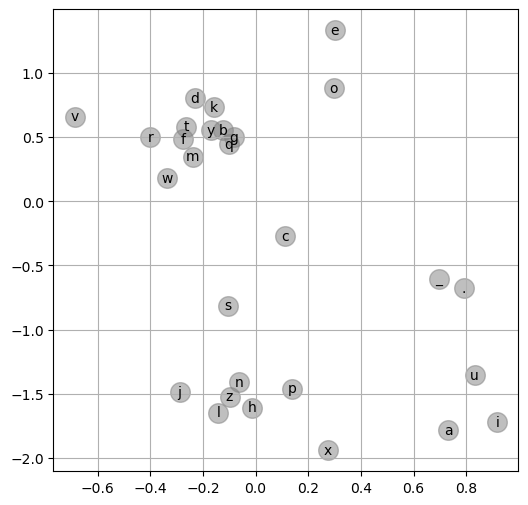

In [170]:
plt.figure(figsize=(6,6)) 
plt.scatter(mlp.C[:,0].data, mlp.C[:,1].data, s = 200,alpha=0.5 , color='gray')
for i in range(C.shape[0]):
    _ = plt.text(mlp.C[i,0].item(), mlp.C[i,1].item(), dec(i), ha='center', va='center', color='black')
plt.grid('minor')
plt.show()

300 hidden layers model

<Figure size 600x600 with 0 Axes>

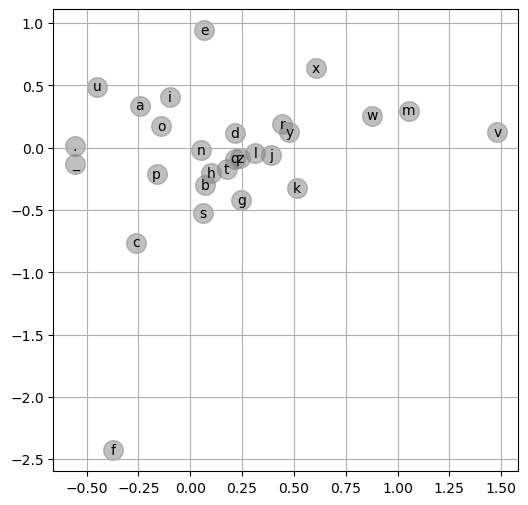

In [171]:
plt.figure(figsize=(6,6)) 
plt.scatter(mlp2.C[:,0].data, mlp2.C[:,1].data, s = 200,alpha=0.5 , color='gray')
for i in range(C.shape[0]):
    _ = plt.text(mlp2.C[i,0].item(), mlp2.C[i,1].item(), dec(i), ha='center', va='center', color='black')
plt.grid('minor')
plt.show()

## 3D Model

In [172]:
mlp3d = MLP(space = 3, 
            block_size = 3, 
            neurons_layer1= 100, 
            neurons_layer2 = len(allchars))
sum(p.nelement() for p in mlp3d.parameters)

3912

In [173]:
mlp3d.sgd(X_train, y_train, alpha = 0.1 , max_iters = 10000)
mlp3d.get_loss(X_valid, y_valid)

0 15.050922393798828
1000 2.3344767093658447
2000 2.344133138656616
3000 2.5453834533691406
4000 2.34667706489563
5000 1.779116153717041
6000 2.357893705368042
7000 2.3561980724334717
8000 1.9345495700836182
9000 1.7637302875518799
10000 1.9759644269943237


tensor(1.9760, grad_fn=<NllLossBackward0>)

tensor(2.1324, grad_fn=<NllLossBackward0>)

In [174]:
mlp3d.sgd(X_train, y_train, alpha = 0.1 , max_iters = 10000)
mlp3d.get_loss(X_valid, y_valid)

0 2.021544933319092
1000 2.193265438079834
2000 2.159817695617676
3000 2.0679128170013428
4000 1.9028160572052002
5000 1.820723056793213
6000 1.9466497898101807
7000 2.022749185562134
8000 1.8490277528762817
9000 1.9413138628005981
10000 2.055288314819336


tensor(2.0553, grad_fn=<NllLossBackward0>)

tensor(2.0610, grad_fn=<NllLossBackward0>)

In [175]:
mlp3d.sgd(X_train, y_train, alpha = 0.01 , max_iters = 10000)
mlp3d.get_loss(X_valid, y_valid)

0 1.873276710510254
1000 2.1550490856170654
2000 2.12054443359375
3000 2.2182445526123047
4000 2.0178582668304443
5000 1.9889682531356812
6000 1.7150238752365112
7000 1.7962853908538818
8000 1.8978612422943115
9000 1.8729240894317627
10000 1.9082764387130737


tensor(1.9083, grad_fn=<NllLossBackward0>)

tensor(1.9978, grad_fn=<NllLossBackward0>)

In [ ]:
mlp3d.get_loss(X_test, y_test)

# Generate words

In [161]:
def generate(model, start = '', max_len = 50):
    word = '.'*model.block_size + start
    for i in range(max_len):
        x = [enc(k) for k in word[-model.block_size:]]
        x = torch.tensor([x])
        logits = model.forward(x)
        p = F.softmax(logits, dim=1)
        word += dec(torch.multinomial(p[0], 1).item())
        if word[-1] == '.':
            break
    return word[model.block_size : -1]

generate(mlp)

'kumralu'

### 2D - n = 100 model

In [163]:
for i in range(10):
    print(generate(mlp))


xampapdatunukureeb
amp_rahmh
senamp
kuran
pdolurikda_gan_singh
bair_tumarir
manf
akti
gow
surrenmp


### 2D - n = 300 model

In [176]:
for i in range(10):
    print(generate(mlp2))

nuvirsha
prim
lam
hehheet
poon
pari_sinju
amrer_sin
soya_shak
ran
tata


### 3D - n = 100 model

In [177]:
for i in range(10):
    print(generate(mlp3d))

nidha_dan
jai
ran
sari
maika_thu
mayata_annadeep
pin
reha
gukrasharla
sub
